# Telecom Churn Analysis & Modeling

## Overview

This project utilizes a dataset of customers from the telecommunications company SyriaTel, analyzing the churn rate of customers (number of customers that stop doing business with the company) by identifying patterns amongst customer features. Additionally, several classification models are built and tuned, then compared to choose the best model for predicting whether customers will stop doing business.   

## Business Problem

The telecom company SyriaTel is concerned with their profits related to customer retention. They want to reduce the amount of money lost because of customers that don't remain with the company for very long. The task is to build a classifier to predict if a customer will soon stop doing business with SyriaTel, by looking for any predictable patterns. 

## Data Understanding

The dataset used for this project is a csv file ("churn_data.csv"), containing over 3,000 customer records and 21 columns. These columns include information on whether they have an international plan or voice mail plan, the totality of calls made and minutes spent on the phone, and the number of calls made to customer service. The target feature is the final column labeled "churn", a binary column indicating whether or not they stopped doing business with the company.  

### Import Libraries

First thing we did was import the necessary libraries for analysis, visualization, preprocessing data, and building models. 

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import log_loss, roc_curve, auc, accuracy_score, f1_score, recall_score, precision_score, ConfusionMatrixDisplay, confusion_matrix
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer

Then we assigned a random state variable to generate the same results.

In [2]:
#set a random state variable
STATE = 42

### Data Inspection

We proceeded to load the csv dataset, then look at the shape, size, column names and data types, as well as check for missing or duplicate entries.

In [3]:
#load the dataset, column names are in the second row
df = pd.read_csv('churn_data.csv', header=1)
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
df.shape

(3333, 21)

In [5]:
df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [6]:
#check the dtype of each column. There are no missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [7]:
#check for duplicates, which there are none
df.duplicated().sum()

0

### Data Manipulation

In this section we added columns that combined the total domestic calls (just as there is a total international calls column irrespective of time of day), as well as a total domestic minutes column for the same reason. 

In [8]:
#add column that combines the total domestic calls
total_dom_calls = df['total day calls'] + df['total eve calls'] + df['total night calls']
df.insert(7, 'total domestic calls', total_dom_calls)
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total domestic calls,total day minutes,total day calls,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,300,265.1,110,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,329,161.6,123,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,328,243.4,114,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,248,299.4,71,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,356,166.7,113,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [9]:
#add column that combines the total domestic minutes
total_dom_mins = df['total day minutes'] + df['total eve minutes'] + df['total night minutes']
df.insert(8, 'total domestic minutes', total_dom_mins)
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total domestic calls,total domestic minutes,total day minutes,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,300,707.2,265.1,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,329,611.5,161.6,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,328,527.2,243.4,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,248,558.2,299.4,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,356,501.9,166.7,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## EDA (Exploratory Data Analysis)

### Target Feature Analysis 

We checked the value counts of our target feature, the "churn" column. We found that there is a great imbalance between False and True values, meaning the vast majority of customers in this dataset have not ceased business, as indicated in a bar graph depicting the value counts as percentages. 

In [10]:
#check the value counts of the churn column
df['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [11]:
#convert the churn counts into percentages in a variable called churn_rate
churn_rate = df['churn'].value_counts() / len(df['churn']) * 100 
churn_rate

False    85.508551
True     14.491449
Name: churn, dtype: float64

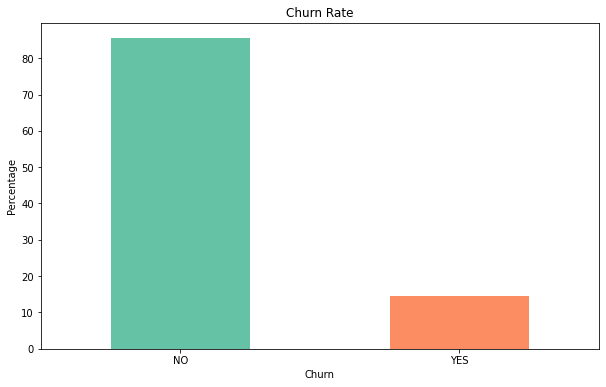

In [12]:
#plot the churn rate and design
fig, ax = plt.subplots(figsize=(10, 6)) 
colors = sns.color_palette('Set2')
churn_rate.plot(kind='bar', ax=ax, color=colors)

#set and format the labels
ax.set_xlabel('Churn')
ax.set_ylabel('Percentage')
ax.set_title('Churn Rate')
ax.set_xticklabels(['NO', 'YES'], rotation=0)

plt.show()

### Target Feature Analysis by Category 

We separated categoric and numeric columns into variables, then proceeded to graph the churn results by category.

In [13]:
#separate categoric and numeric columns into variables
categoric = ['state', 'area code', 'voice mail plan', 'international plan']
numeric = []
for c in df.columns:
    if c not in categoric:
        numeric.append(c)
        
#remove phone number column from the numeric list
numeric.remove('phone number')

First we graphed each categoric column against the churn results. Whether a customer has a voicemail plan seemed to be a significant factor, as well as possibly having an international plan and their area code.

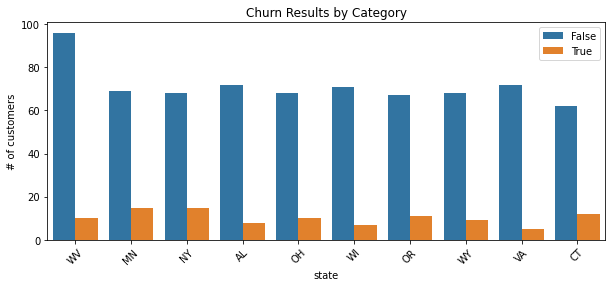

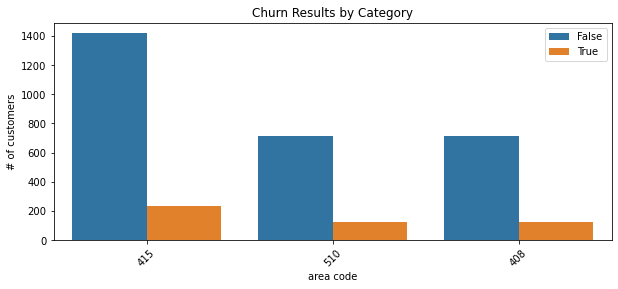

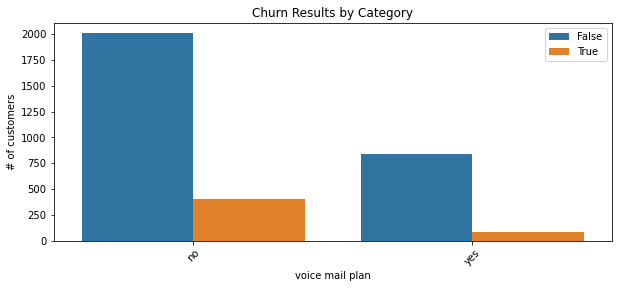

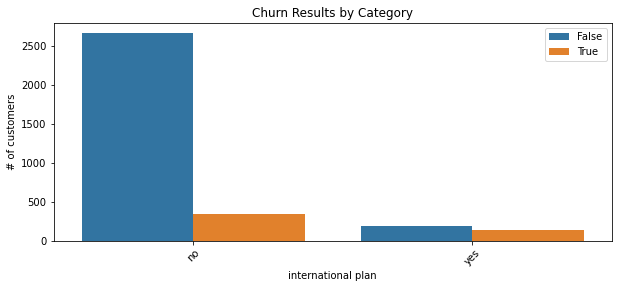

In [14]:
#graph the categoric columns and their churn outcomes
for cat in categoric:
    plt.figure(figsize=(10,4))
    sns.countplot(x=cat, hue="churn", data=df, order= df[cat].value_counts().iloc[0:10].index)
    plt.xticks(rotation=45)
    plt.ylabel('# of customers')
    plt.title('Churn Results by Category')
    plt.legend(loc="upper right")
    plt.show()

### Churn Rate by State

We also looked at the top states of churned customers by grouping them and graphing the top 10 results, first as a total sum, then by average. While Texas has the most churned customers, the rate is actually highest in California and New Jersey.

In [15]:
#group the customers who've dropped the company by state and sort the values in descending order
churn_per_state = df.groupby('state')['churn'].sum().sort_values(ascending=False)
churn_per_state.head()

state
TX    18
NJ    18
MD    17
MI    16
NY    15
Name: churn, dtype: int64

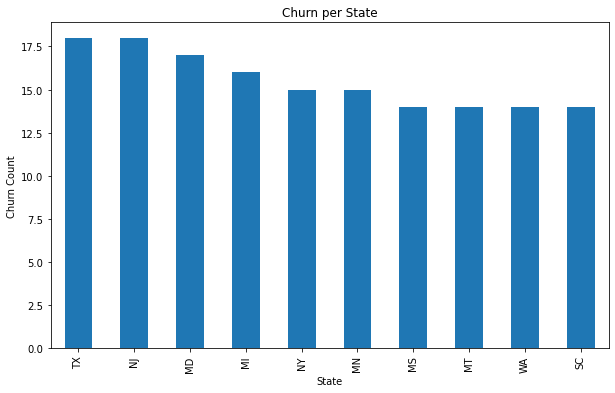

In [16]:
#graph the top 10 churned customers by state
plt.figure(figsize=(10, 6))
churn_per_state[:10].plot(kind='bar')

#set the labels
plt.xlabel('State')
plt.ylabel('Churn Count')
plt.title('Churn per State')

plt.show()

In [17]:
#group the churned customers by state and convert into the mean, sorting the results in descending order
churn_rate_per_state = df.groupby('state')['churn'].mean().sort_values(ascending=False)
churn_rate_per_state.head()

state
CA    0.264706
NJ    0.264706
TX    0.250000
MD    0.242857
SC    0.233333
Name: churn, dtype: float64

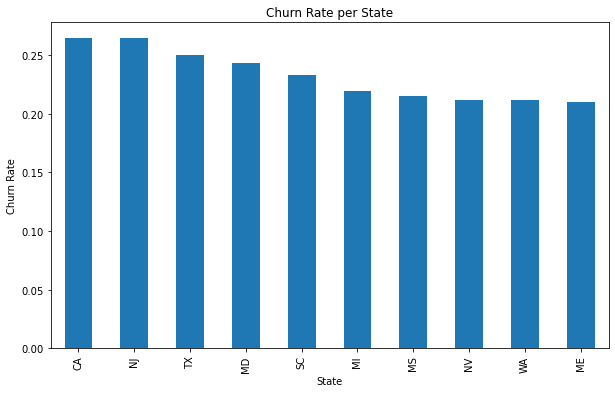

In [18]:
#graph the 10 highest churn rates by state
plt.figure(figsize=(10, 6))
churn_rate_per_state[:10].plot(kind='bar')

#set the labels
plt.xlabel('State')
plt.ylabel('Churn Rate')
plt.title('Churn Rate per State')

plt.show()

### Churn Rate on One Plot

We graphed the categories against the churn rate, not just the total sum, onto one plot to visualize at once. Here it seems that the biggest categoric indicators of a customer ceasing business is if they did not have a voicemail plan, and also if they did in fact have an international plan, which is interesting.

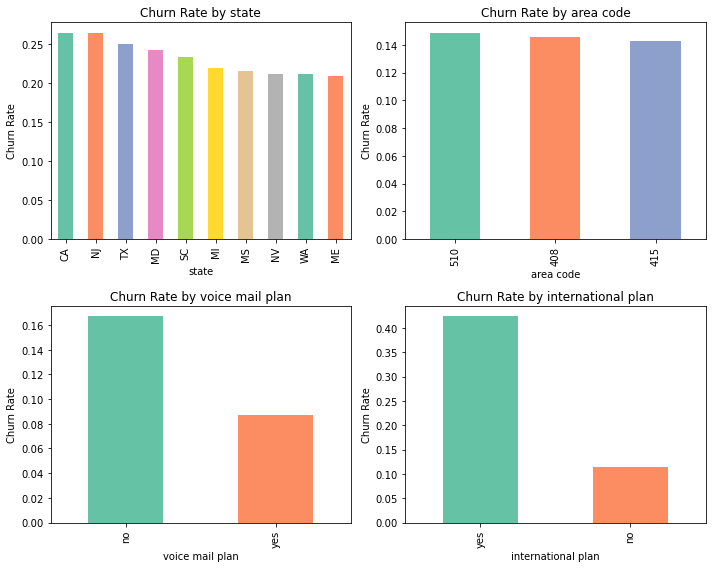

In [19]:
#plot a figure and multiple axes
fig, ax = plt.subplots(2, 2, figsize=(10,8))
ax = ax.ravel()

#iterate over categoric columns
for i, column in enumerate(categoric):
    
    # Calculate the churn rate for each unique value in the column
    churn_rates = df.groupby(column)['churn'].mean().sort_values(ascending=False).head(10)

    # Graph the churn rates
    churn_rates.plot(kind='bar', ax=ax[i], color=sns.color_palette("Set2"))
    
    #set the labels
    ax[i].set_xlabel(column)
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(f'Churn Rate by {column}')
    
    
plt.tight_layout()
plt.show()

### Distribution Curves of Numeric Columns 

We graphed the distribution curve of every numeric column onto one plot. Most have a normal distribution (with some skewness to the right in total international calls and number of voicemail messages), but customer service calls has several modes.

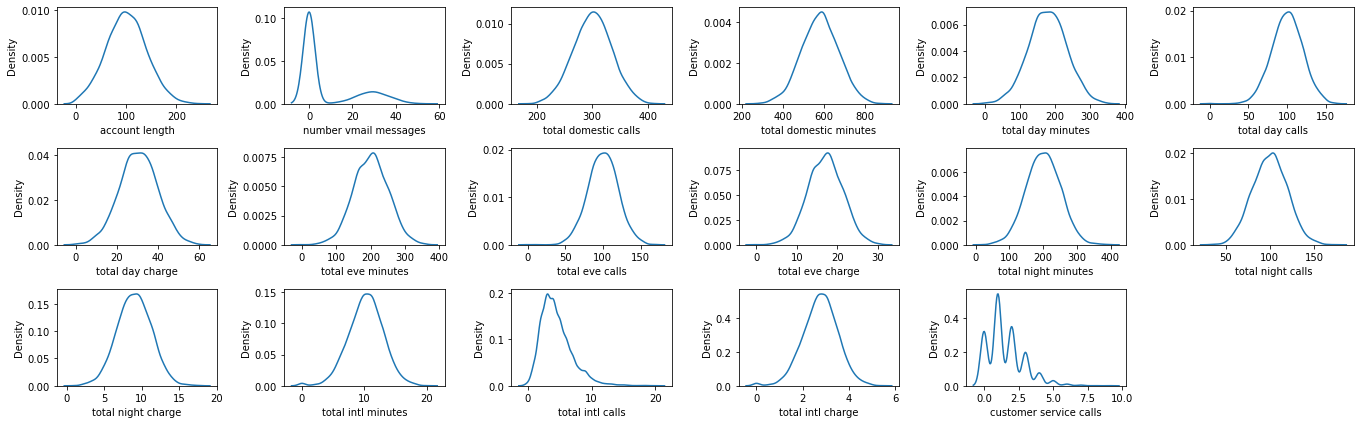

In [20]:
#set a plot and multiple axes
fig, ax = plt.subplots(len(numeric)//5,6,figsize=(19,6))
ax = ax.flatten()

#iterate over the numeric columns and plot distribution curves
for i, j in enumerate(numeric):
    if j != 'churn':
        sns.kdeplot(df[j],ax=ax[i]);
        
#remove the last axis in the bottom right corner since there's no graph there
fig.delaxes(ax[-1])

plt.tight_layout()
plt.show()

### Box Plot

We graphed a box plot of several of the numeric columns and the total churn values. The strongest indicator amongst them was the number of customer service calls. Two or more calls to customer service was a clear indicator of a likelihood that they would soon stop doing business with the company.

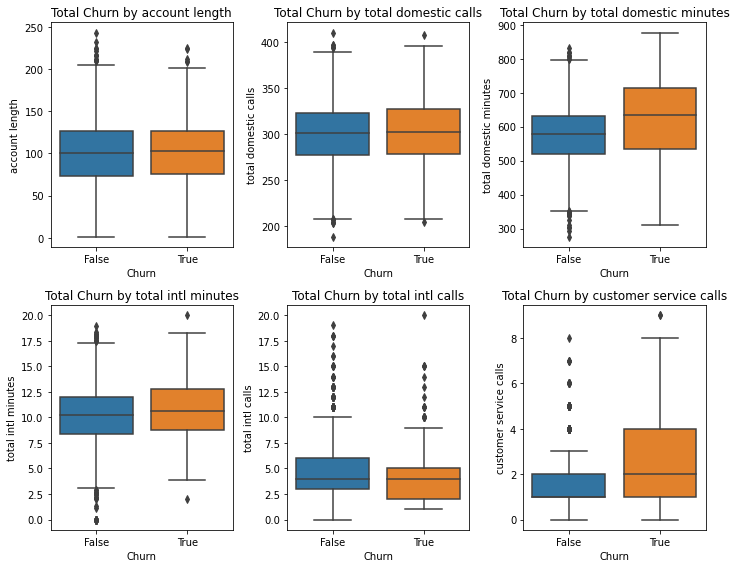

In [21]:
#create a sublist of numeric columns
more_numeric = ['account length', 'total domestic calls', 'total domestic minutes', 'total intl minutes', 'total intl calls', 'customer service calls']

#plot a figure and multiple axes
fig, ax = plt.subplots(2, 3, figsize=(10,8))
ax = ax.ravel()

#iterate over numeric columns
for i, column in enumerate(more_numeric):
    
    # Graph a boxplot of the total churn against each numeric column of the sublist
    sns.boxplot(x='churn', y=column, ax=ax[i], data=df)
    
    #set the labels
    ax[i].set_xlabel('Churn')
    ax[i].set_ylabel(column)
    ax[i].set_title(f'Total Churn by {column}')

plt.tight_layout()
plt.show()

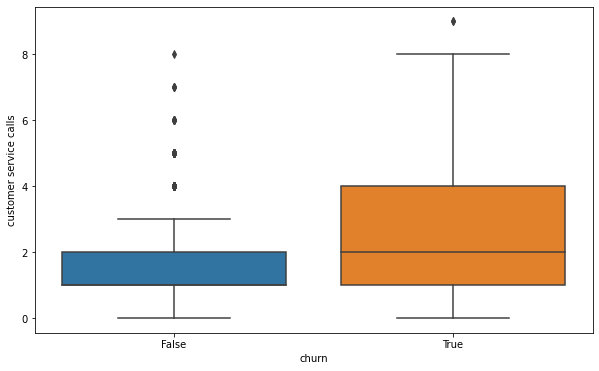

In [22]:
#graph a boxplot to check the typical number of customer service calls for customers that stay vs leave
plt.figure(figsize=(10,6))
sns.boxplot(x='churn', y='customer service calls', data=df)
plt.show()

### Correlation Matrix

We graphed a correlation matrix of all of the numeric columns. There was a perfect correlation between total minutes and total charge, as well as a high correlation between total domestic calls and total calls at different parts of the day. This can risk multicollinearity, so we decided to remove several of the redundant columns

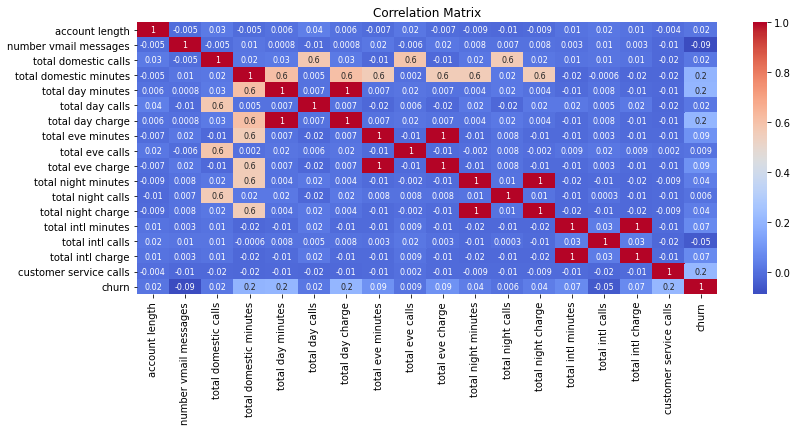

In [23]:
# Compute the correlation matrix
correlation_matrix = df[numeric].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(13, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.0g', annot_kws={"size": 8})
plt.title('Correlation Matrix')


plt.show()

We then proceed to drop the columns that have low correlation to churn or high correlation to other columns. 

## Data Preprocessing

### Train Test Split

We extracted the target feature and the appropriate columns to avoid multicollinearity and overfitting. We then set up a train test split.

In [24]:
#set up datasets for modeling
X = df.drop(['phone number', 'churn'], axis=1)
y = df['churn']

In [25]:
#create a train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=STATE)

### Encoding 

We used pd.get_dummies to one-hot-encode the categorical columns of the data.

In [26]:
#identify categorical columns
categorical_columns_encode = ['area code', 'state', 'voice mail plan', 'international plan']

#one-hot encode categorical columns in X_train
X_train = pd.get_dummies(X_train, columns=categorical_columns_encode)

#one-hot encode categorical columns in X_test
X_test = pd.get_dummies(X_test, columns=categorical_columns_encode)

X_train.head()

,account length,number vmail messages,total domestic calls,total domestic minutes,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,voice mail plan_no,voice mail plan_yes,international plan_no,international plan_yes
367,45,0,335,586.6,78.2,127,13.29,253.4,108,21.54,...,0,0,0,0,0,0,1,0,1,0
3103,115,0,332,736.1,195.9,111,33.30,227.0,108,19.30,...,0,0,0,0,0,0,1,0,1,0
549,121,31,265,639.4,237.1,63,40.31,205.6,117,17.48,...,0,0,0,0,0,0,0,1,1,0
2531,180,0,334,508.0,143.3,134,24.36,180.5,113,15.34,...,0,0,0,0,0,0,1,0,1,0
2378,112,0,317,511.0,206.2,122,35.05,164.5,94,13.98,...,0,0,0,0,0,0,1,0,1,0


### Scaling

We used MinMaxScaler to balance the numeric columns.

In [27]:
#instantiate StandardScaler
scaler = MinMaxScaler()

#select columns to scale
columns_to_scale = ['account length', 'number vmail messages', 'total domestic calls', 'total domestic minutes', 'total intl calls', 'total intl minutes', 'customer service calls']
    
#transform the numeric columns to balance the weight of values for the train data and test data
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

X_train.head()

,account length,number vmail messages,total domestic calls,total domestic minutes,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,voice mail plan_no,voice mail plan_yes,international plan_no,international plan_yes
367,0.190476,0.000000,0.671233,0.522045,78.2,127,13.29,253.4,108,21.54,...,0,0,0,0,0,0,1,0,1,0
3103,0.493506,0.000000,0.657534,0.772674,195.9,111,33.30,227.0,108,19.30,...,0,0,0,0,0,0,1,0,1,0
549,0.519481,0.607843,0.351598,0.610562,237.1,63,40.31,205.6,117,17.48,...,0,0,0,0,0,0,0,1,1,0
2531,0.774892,0.000000,0.666667,0.390277,143.3,134,24.36,180.5,113,15.34,...,0,0,0,0,0,0,1,0,1,0
2378,0.480519,0.000000,0.589041,0.395306,206.2,122,35.05,164.5,94,13.98,...,0,0,0,0,0,0,1,0,1,0


### Convert Target Values

We converted the target values from True and False to 1 and 0, respectively. 

In [28]:
# Convert True and False to 1 and 0 in y_train
y_train = y_train.astype(int)

# Convert True and False to 1 and 0 in y_test
y_test = y_test.astype(int)

### SMOTE

We used the SMOTE method to transform the imbalanced target feature 'churn'. 

In [29]:
#instantiate smote
smote = SMOTE(random_state=STATE)

#fit SMOTE to training data
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train.head() 

,account length,number vmail messages,total domestic calls,total domestic minutes,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,voice mail plan_no,voice mail plan_yes,international plan_no,international plan_yes
0,0.190476,0.000000,0.671233,0.522045,78.2,127,13.29,253.4,108,21.54,...,0,0,0,0,0,0,1,0,1,0
1,0.493506,0.000000,0.657534,0.772674,195.9,111,33.30,227.0,108,19.30,...,0,0,0,0,0,0,1,0,1,0
2,0.519481,0.607843,0.351598,0.610562,237.1,63,40.31,205.6,117,17.48,...,0,0,0,0,0,0,0,1,1,0
3,0.774892,0.000000,0.666667,0.390277,143.3,134,24.36,180.5,113,15.34,...,0,0,0,0,0,0,1,0,1,0
4,0.480519,0.000000,0.589041,0.395306,206.2,122,35.05,164.5,94,13.98,...,0,0,0,0,0,0,1,0,1,0


## Modeling

### Logistic Regression

The first model we created was a logistic regression model.

In [30]:
#create and fit a baseline logistic regression model
logreg = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=STATE)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

Train AUC: 0.969396456845193
Test AUC: 0.8393229901269393


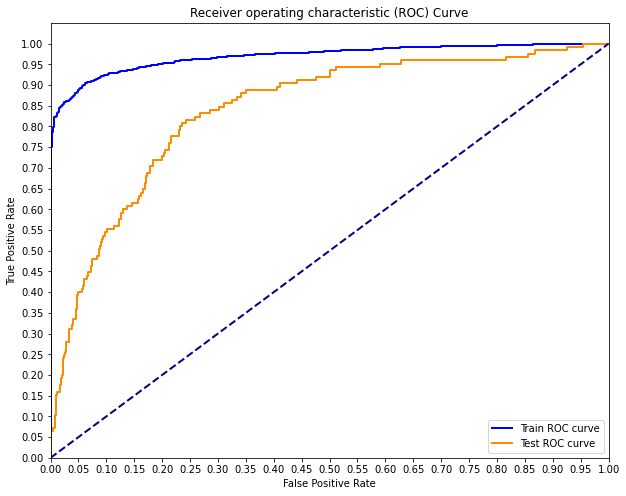

In [31]:
#set up decision scores for the data
y_train_score = logreg.decision_function(X_train)
y_test_score = logreg.decision_function(X_test)

#check the roc curve for the training and testing data
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

plt.figure(figsize=(10, 8))
lw = 2

#graph the ROC curve for the training and testing data to see the results against each other
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Train ROC curve')
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [32]:
# Generate predictions
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

Custom Model Test AUC: 0.6442538787023978
Custome Model Train AUC: 0.9159271368519383


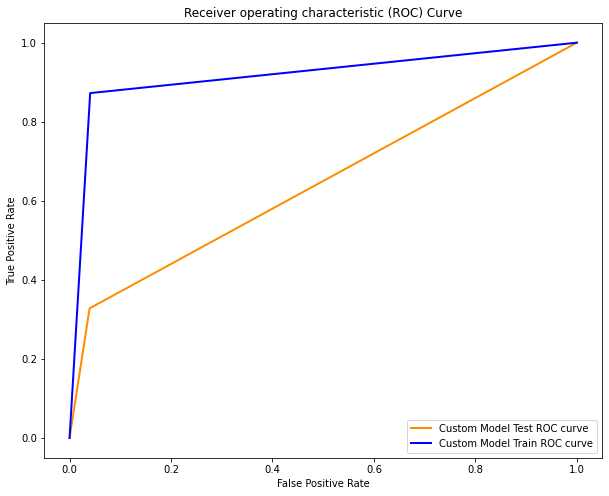

In [33]:
# Initial model plots
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_hat_test)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_hat_train)


print('Custom Model Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Custome Model Train AUC: {}'.format(auc(train_fpr, train_tpr)))

plt.figure(figsize=(10,8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Custom Model Test ROC curve')
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Custom Model Train ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The model performs slightly better on the testing data than the training data. 

LogisticRegression(C=0.005, fit_intercept=False, random_state=42,
                   solver='liblinear')
AUC for 0.005: 0.7776022566995769
-------------------------------------------------------------------------------------
LogisticRegression(C=0.1, fit_intercept=False, random_state=42,
                   solver='liblinear')
AUC for 0.1: 0.8335909732016925
-------------------------------------------------------------------------------------
LogisticRegression(C=0.2, fit_intercept=False, random_state=42,
                   solver='liblinear')
AUC for 0.2: 0.8380141043723554
-------------------------------------------------------------------------------------
LogisticRegression(C=0.5, fit_intercept=False, random_state=42,
                   solver='liblinear')
AUC for 0.5: 0.8399999999999999
-------------------------------------------------------------------------------------
LogisticRegression(C=0.8, fit_intercept=False, random_state=42,
                   solver='liblinear')
AUC for 0

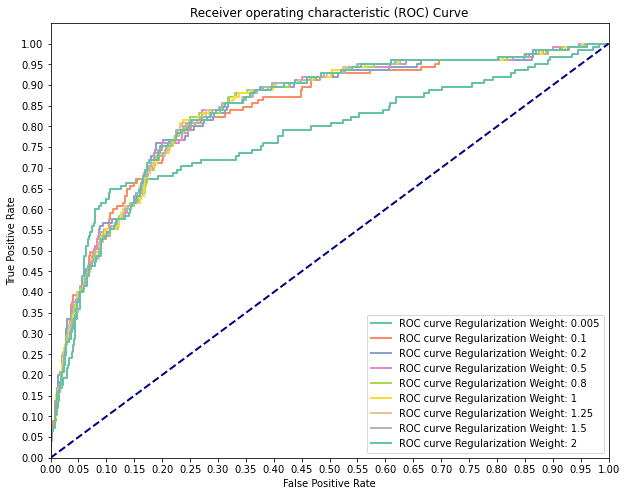

In [34]:
# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

# Write a for loop that builds models for each value of C_param_range, prints the AUC and plots the ROC
for n, c in enumerate(C_param_range):
    # Fit a model 
    logreg = LogisticRegression(fit_intercept=False, C=c, solver ='liblinear', random_state=STATE)
    model_log = logreg.fit(X_train, y_train)
    print(model_log)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))



plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [35]:
#instantiate tuned model
logreg = LogisticRegression(fit_intercept=False, C=2, solver='liblinear', random_state=STATE)
model_log = logreg.fit(X_train, y_train)

#generate predictions
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

#print the scores for metrics
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_hat_test),4))
print('F1 score for testing set: ',round(f1_score(y_test,y_hat_test),4))
print('Recall score for testing set: ',round(recall_score(y_test,y_hat_test),4))
print('Precision score for testing set: ',round(precision_score(y_test,y_hat_test),4))

Accuracy score for testing set:  0.8633
F1 score for testing set:  0.3871
Recall score for testing set:  0.288
Precision score for testing set:  0.5902


Custom Model Test AUC: 0.6263695345557123
Custome Model Train AUC: 0.9203643157403083


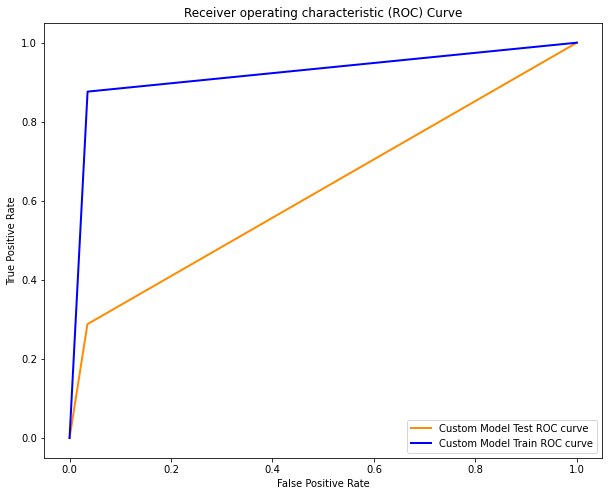

In [36]:
# Initial model plots
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_hat_test)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_hat_train)


print('Custom Model Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Custome Model Train AUC: {}'.format(auc(train_fpr, train_tpr)))

plt.figure(figsize=(10,8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Custom Model Test ROC curve')
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Custom Model Train ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

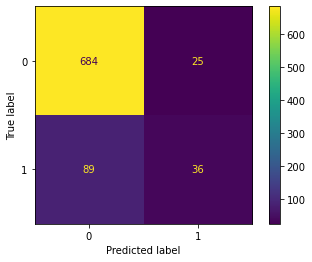

In [37]:
cfm = confusion_matrix(y_test, y_hat_test, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=logreg.classes_)
disp.plot()
plt.show()

In [38]:
# Instantiate the Decision Tree classifier with limited depth
tree = DecisionTreeClassifier(max_depth=5)

# Fit the model to the training data
tree.fit(X_train, y_train)

# Make predictions on the test data
y_pred_tree = tree.predict(X_test)

In [39]:
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_pred_tree),4))
print('F1 score for testing set: ',round(f1_score(y_test,y_pred_tree),4))
print('Recall score for testing set: ',round(recall_score(y_test,y_pred_tree),4))
print('Precision score for testing set: ',round(precision_score(y_test,y_pred_tree),4))

Accuracy score for testing set:  0.9496
F1 score for testing set:  0.822
Recall score for testing set:  0.776
Precision score for testing set:  0.8739


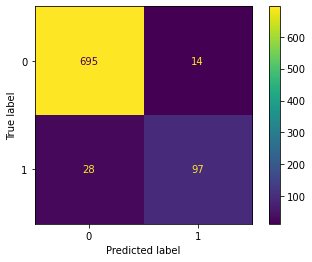

In [40]:
cfm_tree = confusion_matrix(y_test, y_pred_tree, labels=tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm_tree, display_labels=tree.classes_)
disp.plot()
plt.show()

Custom Model Test AUC: 0.8781269393511989
Custome Model Train AUC: 0.9203643157403082


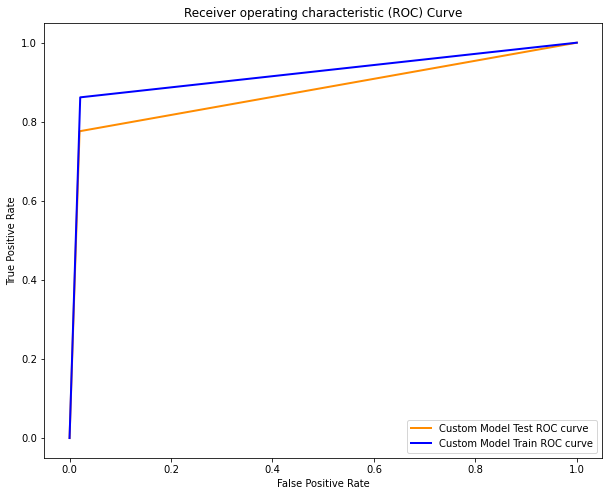

In [41]:
y_tree_train = tree.predict(X_train)

# Initial model plots
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_pred_tree)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_tree_train)


print('Custom Model Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Custome Model Train AUC: {}'.format(auc(train_fpr, train_tpr)))

plt.figure(figsize=(10,8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Custom Model Test ROC curve')
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Custom Model Train ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

DecisionTreeClassifier(max_depth=3, random_state=42)
AUC for 3: 0.8137094499294781
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=3.5, random_state=42)
AUC for 3.5: 0.8137094499294781
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=4, random_state=42)
AUC for 4: 0.8651904090267983
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=4.5, random_state=42)
AUC for 4.5: 0.8651904090267983
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=5, random_state=42)
AUC for 5: 0.8680112834978844
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=5.5, random_state=42)
AUC for 5.5: 0.8680112834978844
------------------------------------------------------------

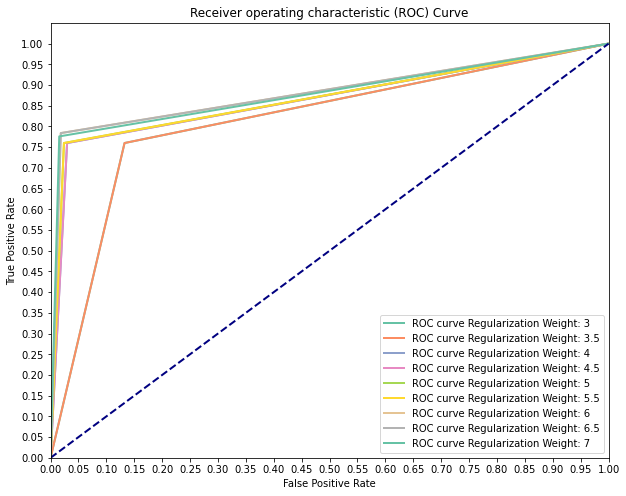

In [42]:
# Now let's compare a few different regularization performances on the dataset
C_param_range = [3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7]
names = [3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

# Write a for loop that builds models for each value of C_param_range, prints the AUC and plots the ROC
for n, c in enumerate(C_param_range):
    # Fit a model 
    tree = DecisionTreeClassifier(max_depth=c, random_state=STATE)
    model_log = tree.fit(X_train, y_train)
    print(model_log)

    # Predict
    y_hat_test_tree = tree.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_hat_test_tree)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))



plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Custom Model Test AUC: 0.8781269393511989
Custome Model Train AUC: 0.952592246613732


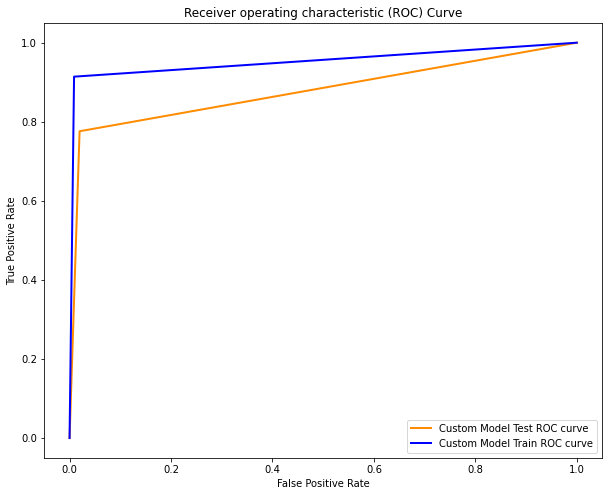

In [43]:
y_tree_train = tree.predict(X_train)

# Initial model plots
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_pred_tree)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_tree_train)


print('Custom Model Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Custome Model Train AUC: {}'.format(auc(train_fpr, train_tpr)))

plt.figure(figsize=(10,8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Custom Model Test ROC curve')
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Custom Model Train ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

DecisionTreeClassifier(max_depth=6, min_samples_split=0.5, random_state=42)
AUC for 0.5: 0.8028998589562766
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=6, min_samples_split=1.0, random_state=42)
AUC for 1.0: 0.593444287729196
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=6, random_state=42)
AUC for 2: 0.8828321579689704
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=6, min_samples_split=3, random_state=42)
AUC for 3: 0.8828321579689704
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=6, min_samples_split=4, random_state=42)
AUC for 4: 0.8828321579689704
-------------------------------------------------------------------------------------
DecisionTreeClassifier(max_depth=6, min_samples_split=5, random_

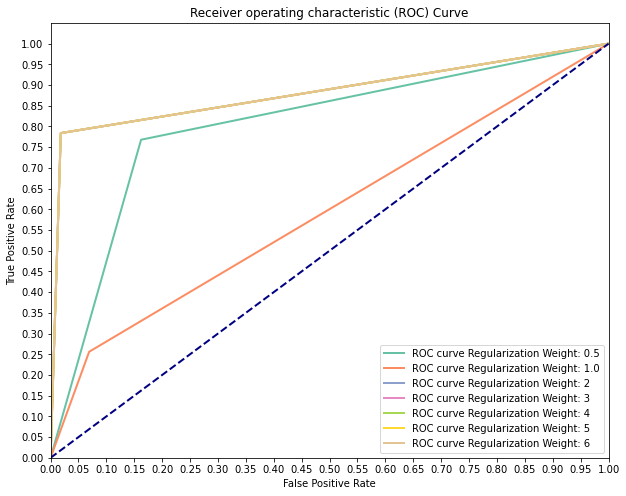

In [44]:
# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.5, 1.0, 2, 3, 4, 5, 6]
names = [0.5, 1.0, 2, 3, 4, 5, 6]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

# Write a for loop that builds models for each value of C_param_range, prints the AUC and plots the ROC
for n, c in enumerate(C_param_range):
    # Fit a model 
    tree = DecisionTreeClassifier(max_depth=6, min_samples_split=c, random_state=STATE)
    model_log = tree.fit(X_train, y_train)
    print(model_log)

    # Predict
    y_hat_test_tree = tree.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_hat_test_tree)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))



plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

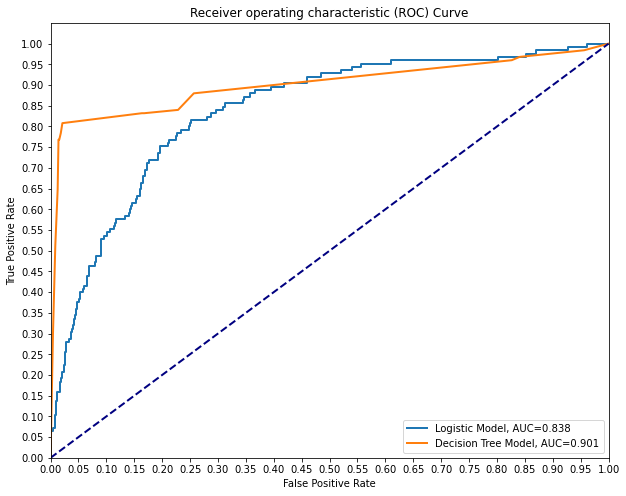

In [45]:
tree = DecisionTreeClassifier(max_depth=6, min_samples_split=4, random_state=STATE)
tree.fit(X_train,y_train)
y_pred_tree = tree.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 8))

y_proba = logreg.predict_proba(X_test)[:, 1]
y_prob = tree.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_prob)


lw = 2
ax.plot(fpr, tpr, lw=lw, label="Logistic Model, AUC={:.3f}".format(auc(fpr, tpr)))
ax.plot(fpr_tree, tpr_tree, lw=lw, label='Decision Tree Model, AUC={:.3f}'.format(auc(fpr_tree, tpr_tree)))


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

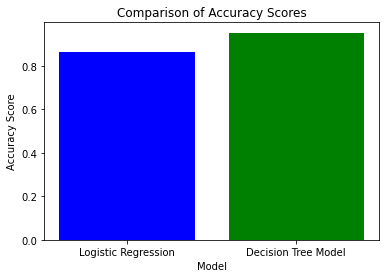

In [46]:
accuracy_scores = [accuracy_score(y_test, y_hat_test), accuracy_score(y_test, y_pred_tree)]
model_names = ['Logistic Regression', 'Decision Tree Model']
# Create a bar graph
plt.bar(model_names, accuracy_scores, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Accuracy Scores')

# Display the bar graph
plt.show()

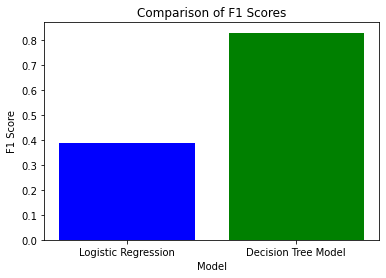

In [47]:
f1_scores = [f1_score(y_test, y_hat_test), f1_score(y_test, y_pred_tree)]

# Create a bar graph
plt.bar(model_names, f1_scores, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores')

# Display the bar graph
plt.show()

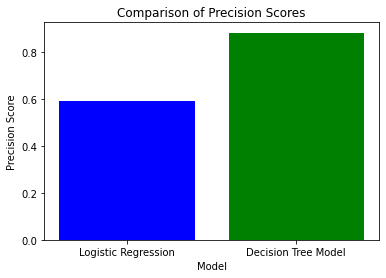

In [48]:
precision_scores = [precision_score(y_test, y_hat_test), precision_score(y_test, y_pred_tree)]

# Create a bar graph
plt.bar(model_names, precision_scores, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Precision Score')
plt.title('Comparison of Precision Scores')

# Display the bar graph
plt.show()

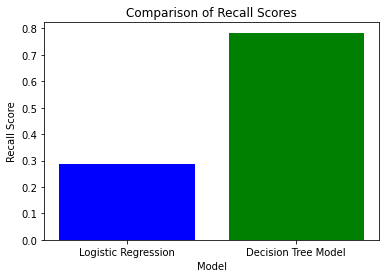

In [49]:
recall_scores = [recall_score(y_test, y_hat_test), recall_score(y_test, y_pred_tree)]

# Create a bar graph
plt.bar(model_names, recall_scores, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Recall Score')
plt.title('Comparison of Recall Scores')

# Display the bar graph
plt.show()